# Example notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import odhin
odhin.__version__

'1.0b3.dev59+gf335444'

## Initialization

Odhin requires a settings file in the YAML format. This file contain all the needed files (cube to process, catalog, HR images and band filters) and parameters.

In [3]:
!pygmentize settings.yml

# The variables defined here are substitued in the file.
vars:
  muse_path: "data"
  hst_path: "data"

# Low Resolution data:
# the cube to deblend, and optionally its white-light image
cube: "{muse_path}/DATACUBE_UDF-10.fits"
white: "{muse_path}/IMAGE_UDF-10.fits"

# High Resolution data:
# segmentation map and associated catalog, list of images
segmap: "{hst_path}/segmentation_map_rafelski_2015.fits"
catalog: "{hst_path}/uvudf_rafelski_2015.fits"
hr_ref_band: "F606W"

# Definition of HR bands, for which we need the file, the filter, and
# for HST the calibration factor to convert pixel values in electrons/s
# to erg cm-2 s-1 Angstrom-1.
#
# http://www.stsci.edu/hst/acs/analysis/zeropoints
# https://acszeropoints.stsci.edu/results_all/?date=&detector=WFC
# There is also a Python API here:
# https://acstools.readthedocs.io/en/latest/acszpt.html
#
hr_bands:
  F606W:
    file: "{hst_path}/hlsp_xdf_hst_acswfc-30mas_hudf_f606w_v1_sci.fits"
    filter: "{hst_path}/HST_ACS_WFC.F606W_81.dat"


In [4]:
# let's create the main object
outdir = 'groups'
debl = odhin.ODHIN('settings.yml', outdir)

WARNING found 12 sources in segmap that are missing in the catalog (ID: [ 6735  7028  7330  7553  8159  8857  9186  9292  9330  9744  9773 10074]), adding them to the catalog


During initialization Odhin found 12 sources in the segmap that are not listed in the catalog. So these sources were added to the catalog, with their ID from the segmentation map.

## Grouping

In [5]:
# create the partition of the data for multiprocessing
debl.grouping(cut=0.005, verbose=True)

WARNING found no sources in group 4



In [6]:
# this creates a groups table
debl.table_groups[:15]

group_id,nb_sources,list_ids,area
int64,int64,object,float64
0,2,"('bg', 22485)",1.0
1,2,"('bg', 4696)",16.0
2,2,"('bg', 22466)",22.0
3,15,"('bg', 4452, 6672, 6775, 10416, 22230, 22252, 22260, 22350, 22351, 22368, 22406, 22410, 25333, 25370)",895.0
4,1,"('bg',)",10.0
5,2,"('bg', 22434)",126.0
6,16,"('bg', 4433, 4554, 4581, 4582, 4596, 4663, 4883, 4999, 5074, 6456, 6490, 6508, 6541, 22287, 22289)",731.0
7,2,"('bg', 10505)",6.0
8,11,"('bg', 4506, 4507, 4575, 4619, 4646, 4657, 4677, 4684, 4703, 10450)",339.0


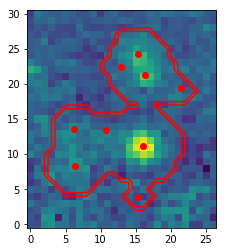

In [7]:
debl.plotAGroup(group_id=13)

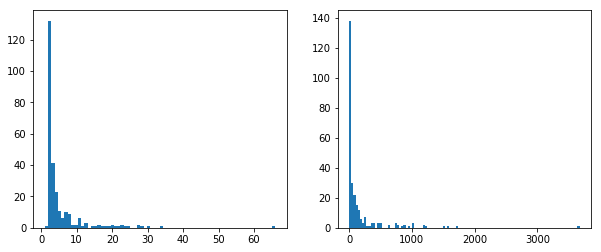

In [8]:
# show histogram of nb of sources
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
debl.plotHistNbS(ax=ax1)
debl.plotHistArea(ax=ax2)

## Deblending

In [9]:
!rm -rf groups/

In [10]:
# do the deblending for a given group
debl.deblend(listGroupToDeblend=[13])

In [11]:
debl.table_sources

id,group_id,xi2,group_area,nb_sources,condition_number,xi2_group,ra,dec
,,,,,,,degrees,degrees
str5,int64,float64,int64,int64,float64,float64,float64,float64
4451,13,0.40966608763232765,277,10,1.8136376768205238,0.4283730926980553,53.16937544,-27.78630885
4460,13,0.41352676997178595,277,10,1.8136376768205238,0.4283730926980553,53.16952435,-27.78641212
4465,13,0.4110619896856303,277,10,1.8136376768205238,0.4283730926980553,53.16930873,-27.78647426
4498,13,0.40874925975702725,277,10,1.8136376768205238,0.4283730926980553,53.16899169,-27.78657868
4564,13,0.43634222770478426,277,10,1.8136376768205238,0.4283730926980553,53.1699427,-27.78690151
4569,13,0.4318966930742678,277,10,1.8136376768205238,0.4283730926980553,53.16965972,-27.78691025
4587,13,0.4332917569889128,277,10,1.8136376768205238,0.4283730926980553,53.16933333,-27.78703805
4615,13,0.45062548028917815,277,10,1.8136376768205238,0.4283730926980553,53.16993487,-27.78719565


In [12]:
debl.table_sources.write(f'{outdir}/catalog.fits')

WARNING UnitsWarning: 'degrees' did not parse as fits unit: At col 0, Unit 'degrees' not supported by the FITS standard. 


## Result files

For each group, a Source file is produced.

In [13]:
ls groups/

catalog.fits  group_00013.fits


In [14]:
from mpdaf.sdetect import Source

src = Source.from_file('groups/group_00013.fits')
src.info()

INFO ID      =                   13 / object ID %d                                   
INFO RA      =    53.16950198918362 / RA u.degree %.7f                               
INFO DEC     =   -27.78686655097766 / DEC u.degree %.7f                              
INFO FROM    = 'Odhin   '           / detection software                             
INFO FROM_V  = '1.0b3.dev59+gf335444' / version of the detection software            
INFO CUBE    = 'DATACUBE_UDF-10.fits' / datacube                                     
INFO CUBE_V  = '1.0b1   '           / version of the datacube                        
INFO SRC_V   = ''                                                                    
INFO GRP_ID  =                   13                                                  
INFO GRP_AREA=                  277                                                  
INFO GRP_NSRC=                   10                                                  
INFO COND_NB =    1.813637676820524                   

In [15]:
src.images, src.spectra

(2 images: MUSE_WHITE FITTED,
 10 spectra: BG 4451 4460 4465 4498 4564 4569 4587 4615 4669)

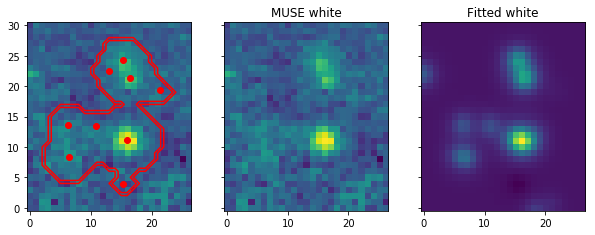

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=True)
debl.plotAGroup(ax=ax1, group_id=13)
src.images['MUSE_WHITE'].plot(ax=ax2, title='MUSE white')
src.images['FITTED'].plot(ax=ax3, title='Fitted white');

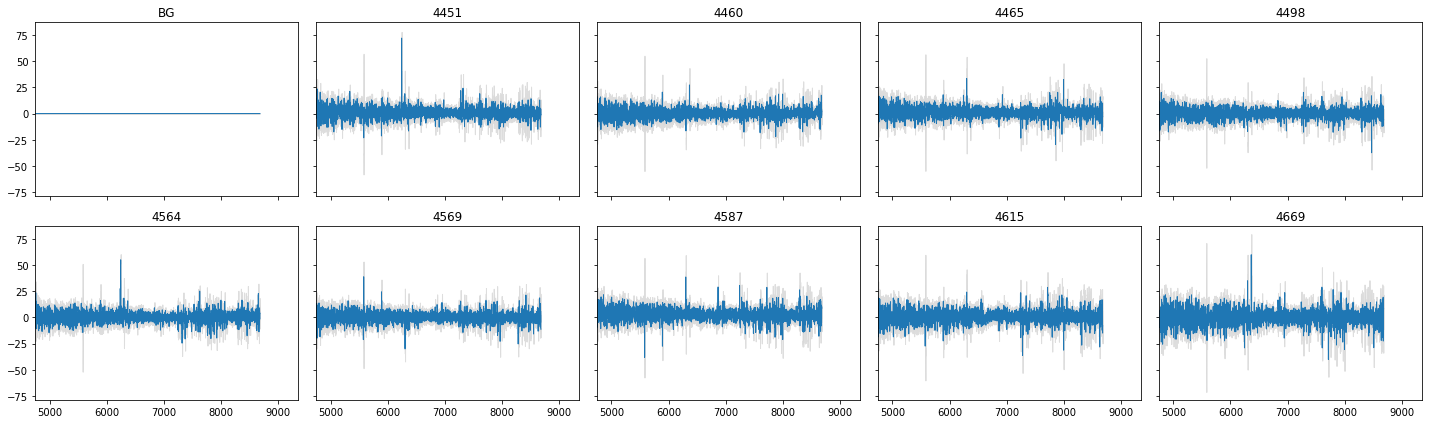

In [17]:
fig, axes = plt.subplots(2, 5, figsize=(5*4, 2*3), sharex=True, sharey=True)
for i, name in enumerate(src.spectra):
    ax = axes.flat[i]
    src.spectra[name].plot(noise=True, ax=ax, title=name)
    ax.set_xlabel('')
fig.tight_layout()